# Insolation stack with alternative age models

The purpose of this notebook is to recreate the plot of the non-detrended speleothem oxygen isotope data with insolation curves. We use alternative age model data procured from SISAL (COPRA and Bacon) to test the sensitivity of these results to the choice of age modeling approach.

In [9]:
import pickle
import os

import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import pyreadr
import matplotlib.transforms as transforms

from matplotlib.ticker import FormatStrFormatter
from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation

In [10]:
# A function to map chron data to paleo data

def mapAgeEnsembleToPaleoData(ensembleValues, paleoValues, ensembleDepth, paleoDepth,
                             value_name = None,value_unit = None,time_name = None,time_unit = None):
    """ Map the depth for the ensemble age values to the paleo values

    Parameters
    ----------

    ensembleValues : array
        A matrix of possible age models. Realizations
        should be stored in columns
        
    paleoValues : 1D array
        A vector containing the paleo data values. The vector
        should have the same length as depthPaleo
        
    ensembleDepth : 1D array
        A vector of depth. The vector should have the same
        length as the number of rows in the ensembleValues
        
    paleoDepth : 1D array
        A vector corresponding to the depth at which there
        are paleodata information
        
    value_name : str
        Paleo data value name
    
    value_unit : str
        Paleo data value unit
    
    time_name : str
        Time name
    
    time_unit : str
        Time unit

    Returns
    -------

    ensemble : pyleoclim.EnsembleSeries
        A matrix of age ensemble on the PaleoData scale

    """

    #Make sure that numpy arrays were given and try to coerce them into vectors if possible
    ensembleDepth=np.squeeze(np.array(ensembleDepth))
    paleoValues = np.squeeze(np.array(paleoValues))
    paleoDepth = np.squeeze(np.array(paleoDepth))

    #Check that arrays are vectors for np.interp
    if paleoValues.ndim > 1:
        raise ValueError('ensembleValues has more than one dimension, please pass it as a 1D array')
    if ensembleDepth.ndim > 1:
        raise ValueError('ensembleDepth has more than one dimension, please pass it as a 1D array')
    if paleoDepth.ndim > 1:
        raise ValueError('paleoDepth has more than one dimension, please pass it as a 1D array')

    if len(ensembleDepth)!=np.shape(ensembleValues)[0]:
        raise ValueError("Ensemble depth and age need to have the same length")
    if len(paleoValues) != len(paleoDepth):
        raise ValueError("Paleo depth and age need to have the same length")

    #Interpolate
    ensembleValuesToPaleo = np.zeros((len(paleoDepth),np.shape(ensembleValues)[1])) #placeholder
    
    for i in np.arange(0,np.shape(ensembleValues)[1]):
        fp,xp = pyleo.utils.tsbase.dropna(ensembleValues[:,i],ensembleDepth) #drop nans
        ensembleValuesToPaleo[:,i]=np.interp(paleoDepth,xp,fp)
    
    series_list = []
    
    for s in ensembleValuesToPaleo.T:
        series_tmp = pyleo.Series(time=s, value=paleoValues,
                       verbose=False,
                       clean_ts=False,
                       value_name=value_name,
                       value_unit=value_unit,
                       time_name=time_name,
                       time_unit=time_unit)
        series_list.append(series_tmp)
    
    ensemble = pyleo.EnsembleSeries(series_list=series_list) #Only including the holocene

    return ensemble

In [11]:
# Mapping stalagmite names to cave sites

cave_site_dict = {
    'HS4' : 'Heshang',
#    'SB43' : 'Sanbao',
    'C9961' : 'Jiuxian',
    'LH-2' : 'Lianhua',
    'KMA' : 'Mawmluh',
    'XL26' : 'Xianglong',
    'DA' : 'Dongge',
    'SAH2' : 'Sahiya',
    'Hq-1' : 'Hoq',
#    'D1' : 'Dark',
#    'SN17' : 'Shennong',
    'TA12-2' : 'Tangga',
    'LAVI-4' : 'LaVierge',
    'Q5' : 'Oman'
}

In [12]:
with open('../data/holo_chrons_study.pkl','rb') as handle:
    holo_chrons = pickle.load(handle)

with open('../data/preprocessed_series_dict.pkl','rb') as handle:
    series_dict = pickle.load(handle)

with open('../data/pos_dict.pkl','rb') as handle:
    pos_dict = pickle.load(handle)

with open('../data/palette_dict.pkl','rb') as handle:
    color_palette = pickle.load(handle)

In [13]:
# Sorting by latitude

lat_dict = {series.lat:series.label for series in series_dict.values()}

sort_index = np.sort(np.array(list(lat_dict.keys())))[::-1]
sort_label = [lat_dict[lat] for lat in sort_index]

In [14]:
# Creating local insolation curves for each record

inso_dict = {}
# array with specified kyears (can be plain numpy or xarray.DataArray)
years = np.arange(-1000, 0)

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=years)

#Day numbers from June 1st to August 31st
june21 = 172

for label,pos in pos_dict.items():
    lat = pos['lat']
    inso = daily_insolation(lat=lat, day=june21, orb=orb)
    inso_series = pyleo.Series(time=0-years[::-1],value=inso[::-1],time_name='Age',time_unit='Kyr BP',value_name=f'JJA Insolation {lat} N',value_unit='W/m^2',verbose=False).convert_time_unit('Years BP')
    inso_dict[label] = inso_series

Creating the stack with Bacon data:

In [15]:
bacon_dir = '../../data/alt_chrons/SISAL_Bacon/'
bacon_files = os.listdir(bacon_dir)
bacon_dict = {}

for file in bacon_files:
    res = pyreadr.read_r(f'{bacon_dir}{file}')
    name = cave_site_dict[file.split('Bacon')[0][:-1]]
    res_key = list(res.keys())[0]
    bacon_dict[name] = res[res_key]

In [16]:
# Creating BACON ensembles
bacon_ens = {}

# Iterate over each label in bacon_dict
for label in bacon_dict.keys():
    # Get the paleo depth and values from holo_chrons dictionary
    paleo_depth = holo_chrons[label]['depth']
    paleo_values = holo_chrons[label]['d18O']
    
    # Check if the label is not 'Heshang'
    if label not in ['Heshang']:
        # Convert ensemble depth to mm by multiplying by 10
        ensemble_depth = bacon_dict[label]['depth_sample'] * 10
    else:
        # Use the ensemble depth as is for 'Heshang'
        ensemble_depth = bacon_dict[label]['depth_sample']
    
    # Get the list of value columns from bacon_dict
    value_columns = list(bacon_dict[label].columns)[2:]
    
    # Get the ensemble values from bacon_dict
    ensemble_values = bacon_dict[label][value_columns].values
    
    # Map the age ensemble to paleo data using the mapAgeEnsembleToPaleoData function
    ens = mapAgeEnsembleToPaleoData(ensembleValues=ensemble_values,
                                    paleoValues=paleo_values,
                                    ensembleDepth=ensemble_depth,
                                    paleoDepth=paleo_depth)
    
    # Store the mapped ensemble in bacon_ens dictionary with the label as the key
    bacon_ens[label] = ens

# Sort bacon_ens dictionary by latitude using the sort_label list
bacon_ens = {label: bacon_ens[label] for label in sort_label if label in bacon_ens.keys()}

/Users/alexjames/miniconda3/envs/docs/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


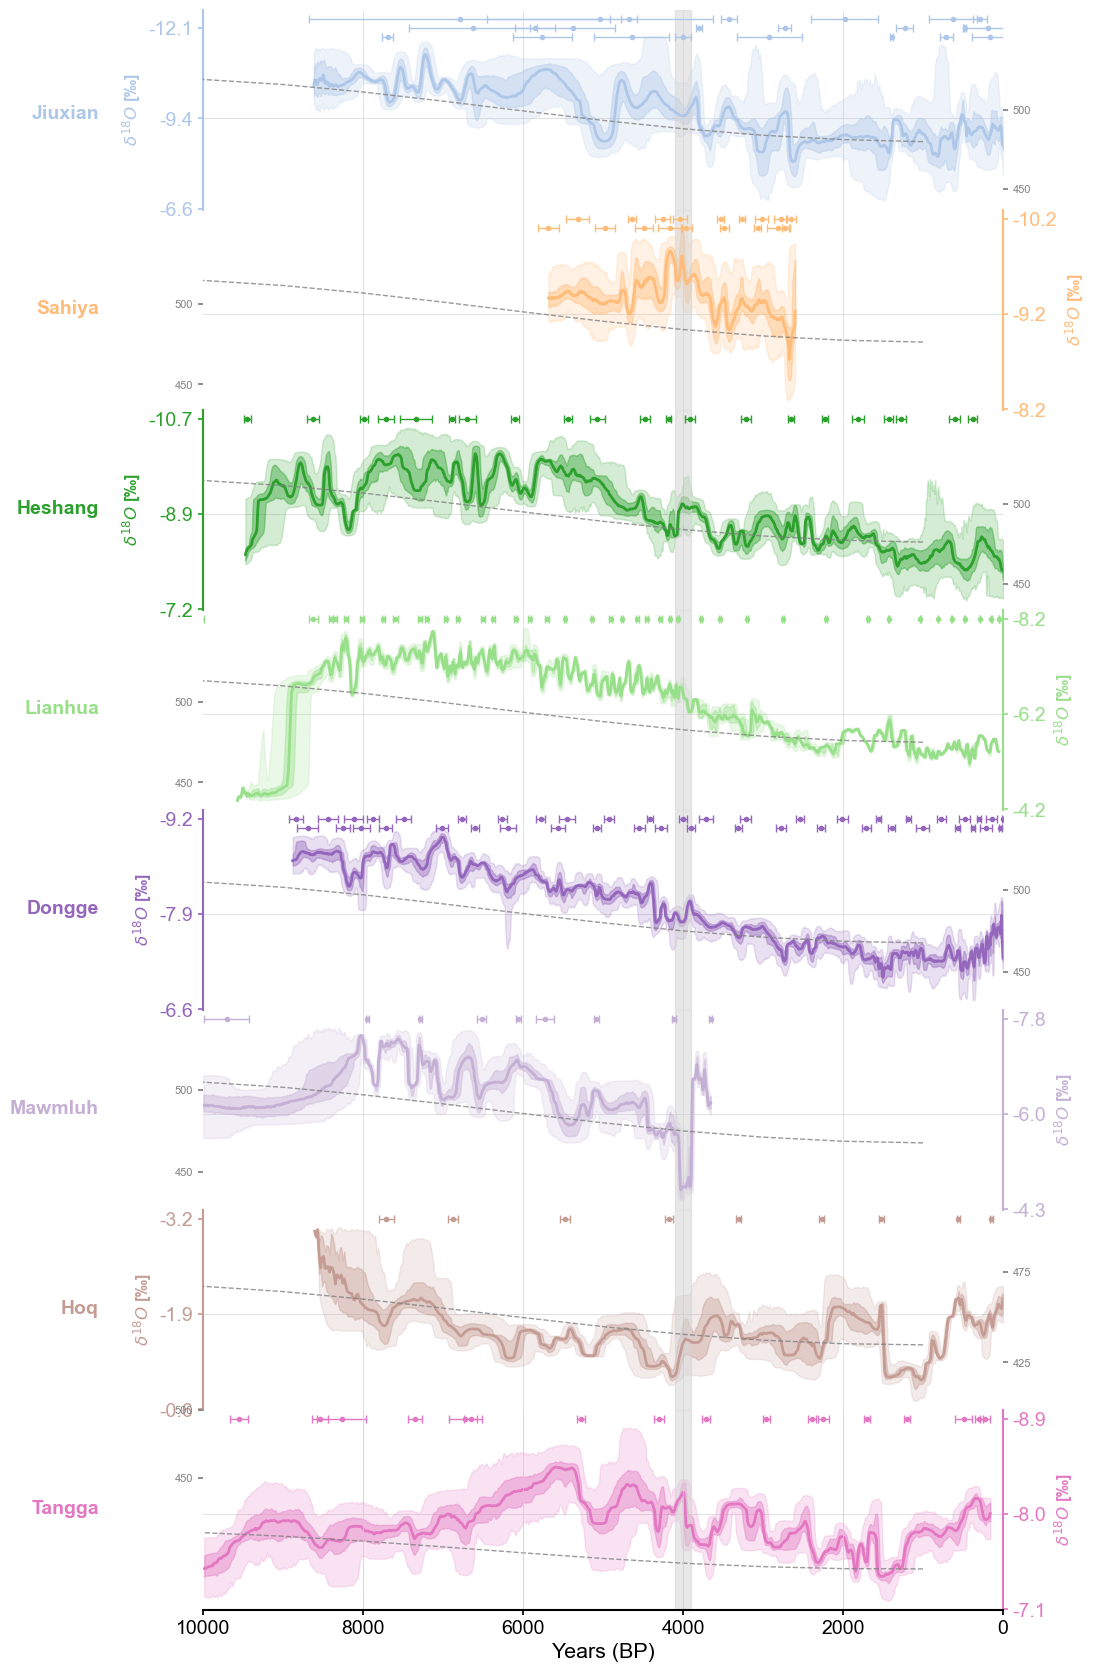

In [17]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(bacon_ens)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

# Iterate over each pair in bacon_ens
for idx, pair in enumerate(bacon_ens.items()):
    label, ens = pair
    color = color_palette[label]
    bottom -= height * v_shift_factor
    ax[idx] = fig.add_axes([left, bottom, width, height])
    
    # Plot the ensemble envelope
    ens.common_time(time_axis=series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)
    
    # Create a twin y-axis
    ax2 = ax[idx].twinx()
    ax2.grid(False)
    
    # Plot the insolation data on the twin y-axis
    inso_dict[label].plot(ax=ax2, color='grey', alpha=.8, linestyle='--', linewidth=1, ylabel='')
    
    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)
    
    # Add labels to the plot
    ylim = ax[idx].get_ylim()
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.13, np.mean(ylim), label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ax[idx].set_yticks([ylim[0], np.mean(ylim), ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)
    
    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.tick_right()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.tick_left()
    
    # Add error bars to the plot based on the label
    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05
    if label in ['Xianglong', 'Dongge', 'Sahiya', 'Liuli']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::2], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::2]), xerr=holo_chrons[label]['dating_error'][0::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::2], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::2]), xerr=holo_chrons[label]['dating_error'][1::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    elif label in ['Jiuxian', 'Jiulong']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::3], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::3]), xerr=holo_chrons[label]['dating_error'][0::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::3], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::3]), xerr=holo_chrons[label]['dating_error'][1::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][2::3], [ylim[0] - offset] * len(holo_chrons[label]['dating_age'][2::3]), xerr=holo_chrons[label]['dating_error'][2::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    else:
        ax[idx].errorbar(holo_chrons[label]['dating_age'], [ylim[0]] * len(holo_chrons[label]['dating_age']), xerr=holo_chrons[label]['dating_error'], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    
    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=np.mean(ylim), color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4100, 3900, color='lightgrey', alpha=0.5)
    
    # Set properties for the twin y-axis
    ax2.tick_params(axis='y', colors='grey', labelsize=8)
    if label in ['Hoq']:
        yticks2 = [425, 475]
    else:
        yticks2 = [450, 500]
    ax2.set_yticks(yticks2)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.tick_params(axis='x', which='both', length=0)
    ax2.set_xlabel('')
    ax2.set_xticklabels([])
    ax2.legend([])

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

In [18]:
pyleo.savefig(fig,'../figures/bacon_ensemble_inso.pdf')

Figure saved at: "../../figures/bacon_ensemble_inso.pdf"


Creating the insolation stack with COPRA data:

In [19]:
copra_dir = '../../data/alt_chrons/SISAL_COPRA/'
copra_files = os.listdir(copra_dir)
copra_dict = {}

for file in copra_files:
    res = pyreadr.read_r(f'{copra_dir}{file}')
    name = cave_site_dict[file.split('copRa')[0][:-1]]
    res_key = list(res.keys())[0]
    copra_dict[name] = res[res_key]

In [20]:
# Creating COPRA ensembles
copra_ens = {}

# Iterate over each label in copra_dict
for label in copra_dict.keys():
    # Get the paleo depth and values from holo_chrons dictionary
    paleo_depth = holo_chrons[label]['depth']
    paleo_values = holo_chrons[label]['d18O']
    
    # Check if the label is 'Heshang'
    if label in ['Heshang']:
        # Convert ensemble depth from cm to mm by dividing by 10
        ensemble_depth = copra_dict[label]['depth_sample'] / 10
    else:
        # Use the ensemble depth as is
        ensemble_depth = copra_dict[label]['depth_sample']
    
    # Get the list of value columns from copra_dict
    value_columns = list(copra_dict[label].columns)[2:]
    
    # Get the ensemble values from copra_dict
    ensemble_values = copra_dict[label][value_columns].values
    
    # Map the age ensemble to paleo data using the mapAgeEnsembleToPaleoData function
    ens = mapAgeEnsembleToPaleoData(ensembleValues=ensemble_values,
                                    paleoValues=paleo_values,
                                    ensembleDepth=ensemble_depth,
                                    paleoDepth=paleo_depth)
    
    # Store the mapped ensemble in copra_ens dictionary with the label as the key
    copra_ens[label] = ens

# Sort copra_ens dictionary by latitude using the sort_label list
copra_ens = {label: copra_ens[label] for label in sort_label if label in copra_ens.keys()}

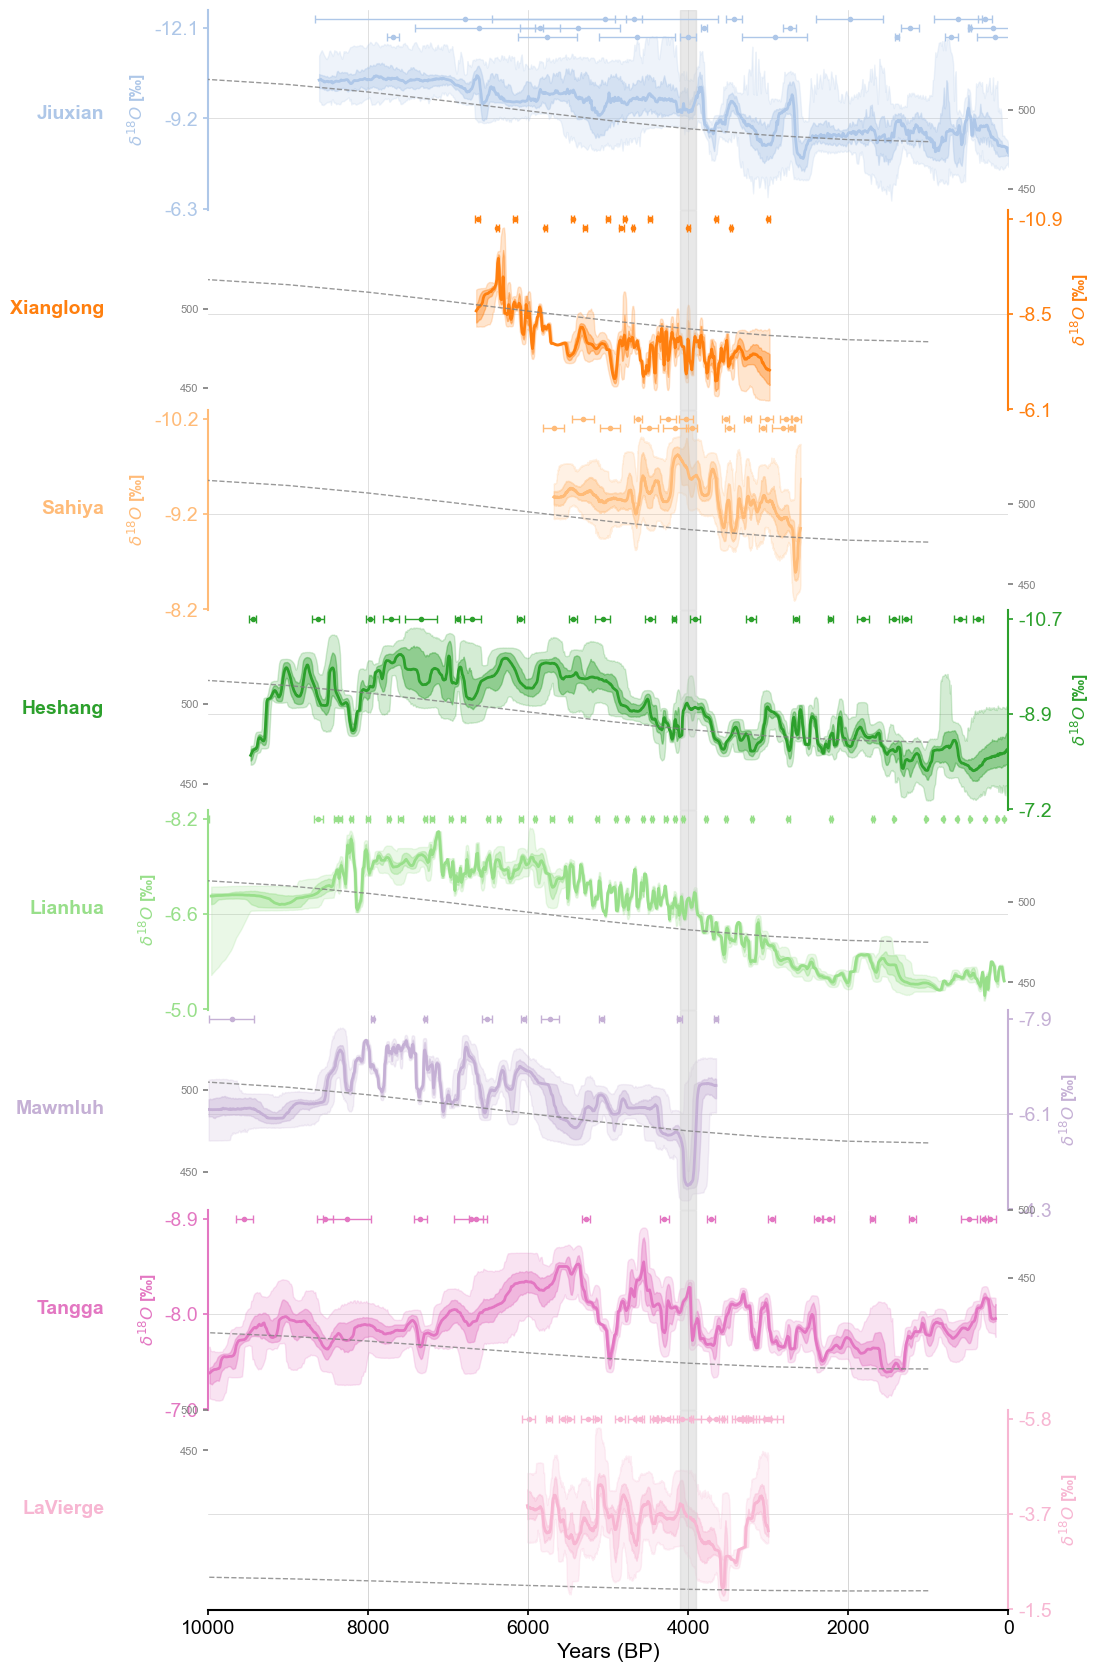

In [21]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(copra_ens)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

# Iterate over each pair in copra_ens
for idx, pair in enumerate(copra_ens.items()):
    label, ens = pair
    color = color_palette[label]
    bottom -= height * v_shift_factor
    ax[idx] = fig.add_axes([left, bottom, width, height])
    
    # Plot the ensemble envelope
    ens.common_time(time_axis=series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)
    
    # Create a twin y-axis
    ax2 = ax[idx].twinx()
    ax2.grid(False)
    
    # Plot the insolation data on the twin y-axis
    inso_dict[label].plot(ax=ax2, color='grey', alpha=.8, linestyle='--', linewidth=1, ylabel='')
    
    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)
    
    # Add labels to the plot
    ylim = ax[idx].get_ylim()
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.13, np.mean(ylim), label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    ax[idx].set_yticks([ylim[0], np.mean(ylim), ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)
    
    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.tick_right()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.tick_left()
    
    # Add error bars to the plot based on the label
    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05
    if label in ['Xianglong', 'Dongge', 'Sahiya', 'Liuli']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::2], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::2]), xerr=holo_chrons[label]['dating_error'][0::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::2], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::2]), xerr=holo_chrons[label]['dating_error'][1::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    elif label in ['Jiuxian', 'Jiulong']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::3], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::3]), xerr=holo_chrons[label]['dating_error'][0::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::3], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::3]), xerr=holo_chrons[label]['dating_error'][1::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][2::3], [ylim[0] - offset] * len(holo_chrons[label]['dating_age'][2::3]), xerr=holo_chrons[label]['dating_error'][2::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    else:
        ax[idx].errorbar(holo_chrons[label]['dating_age'], [ylim[0]] * len(holo_chrons[label]['dating_age']), xerr=holo_chrons[label]['dating_error'], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    
    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=np.mean(ylim), color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()
    ax[idx].axvspan(4100, 3900, color='lightgrey', alpha=0.5)
    
    # Set properties for the twin y-axis
    ax2.tick_params(axis='y', colors='grey', labelsize=8)
    if label in ['Hoq']:
        yticks2 = [425, 475]
    else:
        yticks2 = [450, 500]
    ax2.set_yticks(yticks2)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.tick_params(axis='x', which='both', length=0)
    ax2.set_xlabel('')
    ax2.set_xticklabels([])
    ax2.legend([])

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

In [22]:
pyleo.savefig(fig,'../figures/copra_ensemble_inso.pdf')

Figure saved at: "../../figures/copra_ensemble_inso.pdf"
